# Comparing DBSCAN and HDBSCAN clustering
## Objectives

* Use scikit-learn to implement DBSCAN and HDBSCAN clustering models to real data
* Compare the performances of the two models

In [1]:
# !pip install numpy==2.2.0
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.6.0
# !pip install matplotlib==3.9.3
# !pip install hdbscan==0.8.40
# !pip install geopandas==1.0.1
# !pip install contextily==1.6.2
# !pip install shapely==2.0.6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

# Download the Canada map for reference

In [2]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


# Include a plotting function

In [3]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Explore the data and extract what you need from it

In [7]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


# Exercise 1. Explore the table. What do missing values look like in this data set?

* Strings consisting of two dots '..' indicate missing values. There miight still be empty fields, or NaNs.

# Exercise 2. Display the facility types and their counts

In [8]:
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

# Exercise 3. Filter the data to only include museums.

In [9]:
df = df[df.ODCAF_Facility_Type == 'museum']
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

# Exercise 4. Select only the Latitude and Longitude features as inputs to our clustering problem.

In [10]:
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


# Exercise 5. We'll need these coordinates to be floats, not objects

In [14]:
df.sample(20)

,Latitude,Longitude
2328,48.749205,-79.287679
5616,..,..
7317,42.31122465,-83.03428894
3704,43.50743362,-79.94368811
3640,..,..
2406,42.79539508,-81.64765255
4122,43.1472183,-79.37075509
3477,45.401857,-75.70510981
5824,47.457606,-70.363798
6430,..,..


In [15]:
# Remove observations with no coordinates 
df = df[df.Latitude!='..']

# Convert to float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   1607 non-null   float64
 1   Longitude  1607 non-null   float64
dtypes: float64(2)
memory usage: 37.7 KB


# Build a DBSCAN model

In [18]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees,
# the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

# Apply DBSCAN with Euclidean distance to the scaled coordinates

In [19]:
min_samples=3 # minimum number of samples needed to form a neighbourhood
eps=1.0 # neighbourhood search radius
metric='euclidean' # distance measure 

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

# Add cluster labels to the DataFrame

In [20]:
df['Cluster'] = dbscan.fit_predict(coords_scaled)  # Assign the cluster labels

# Display the size of each cluster
df['Cluster'].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 24      6
 18      6
 28      6
 26      6
 14      6
 5       6
 22      4
 9       4
 13      4
 30      3
 31      3
 29      3
 0       3
 25      3
 23      3
 21      3
 17      3
 32      3
Name: count, dtype: int64

# Plot the museums on a basemap of Canada, colored by cluster label

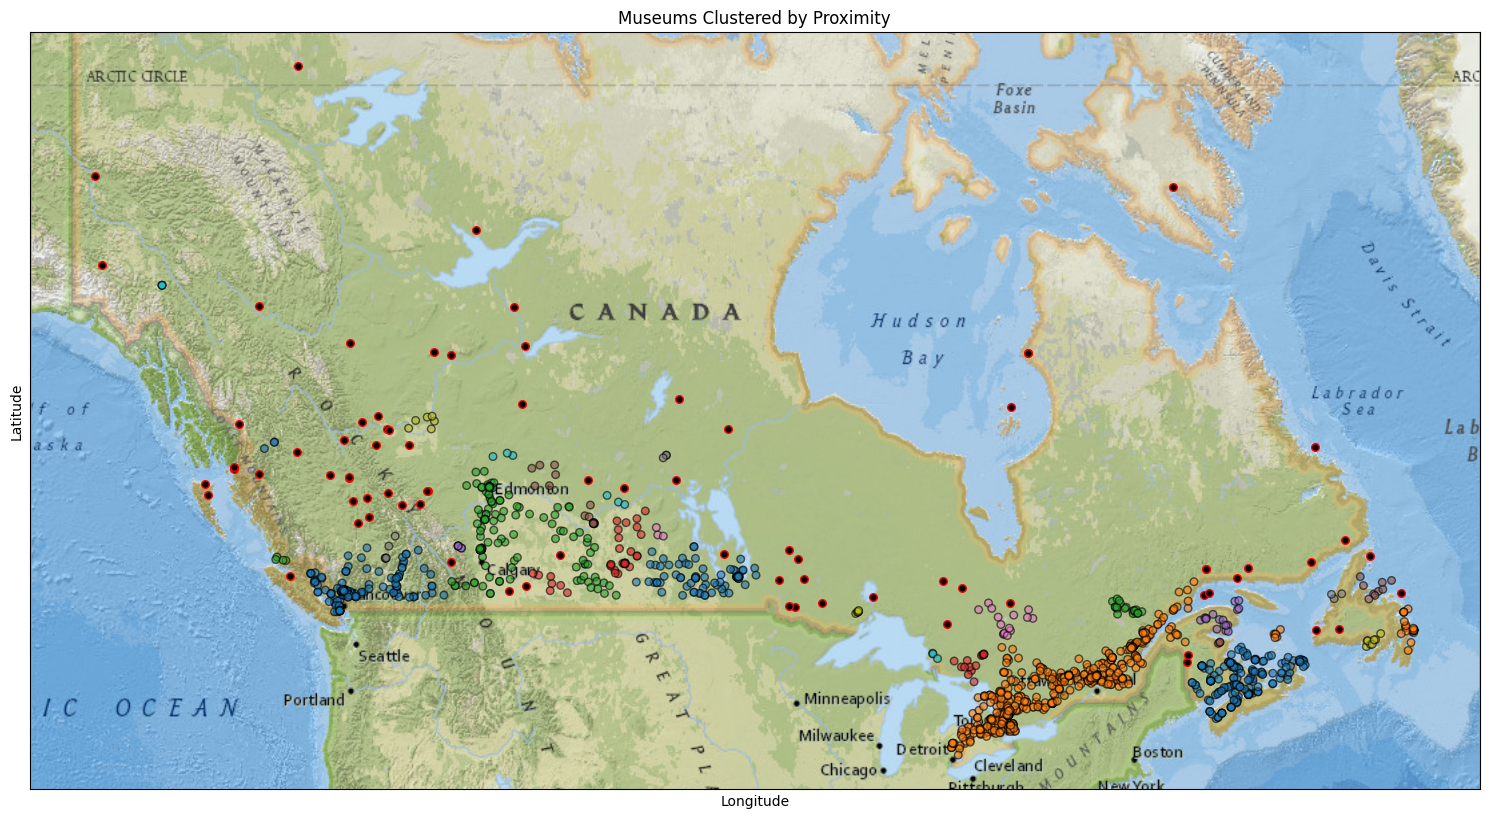

In [21]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')